# Predict Consumption

### Goal: using the KWH predict consumption

## Approach
1. EDA
2. Cleaning / Tranformations
3. Baseline model
4. Eval model
5. Feature engineering
6. Try different models / combos

### Thoughts
- Should I run a check that all the dtypes in the data file are the same as intended in the 'public_layout' file? Could be a good data quality check to automate for the datapipeline

### Assumptions
- All data appart from taget variable will be aviable to use as features for prediction (we can use all columns....)... but lets investigate?
    - Issue: there is data leak and perfect R2 score.... so surely there are some columns not to use 
- Assumne where -2 value is pressent that means no data/ null 
- 'BTUEL' col is a 1:1 correlation with the target variable... and thur removed to eliminate data leakage

### Imports

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline

## Data EDA

### Load data

In [4]:
dpath = '../data/'

df1 = pd.read_csv(dpath + 'recs2009_public.csv')
df_lay = pd.read_csv(dpath + "public_layout.csv")
df_w = pd.read_csv(dpath + "recs2009_public_repweights.csv")

/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Public File

In [5]:
print(df1.shape)
df1.head()

(12083, 940)


,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90


#### **Explore Object columns**
5 columns: 
- METROMICRO
- UR
- NOCRCASH
- NKRGALNC
- IECC_Climate_Pub

Pipeline: 
1. Clean text (strip etc)
2. Remove rows with "." 
3. Replace "-2" with 0 
    - "NOCRCASH"  
    - "NKRGALNC" columns
4. Encode
    - "METROMICRO"
    - "UR"
    - "IECC_Climate_Pub"
5. Remove columns
    - 'BTUEL' because of data leak
    - any others?


In [6]:
obj_cols = df1.select_dtypes(include=['object'])
obj_cols.head()

,METROMICRO,UR,NOCRCASH,NKRGALNC,IECC_Climate_Pub
0,METRO,U,-2,-2,4A
1,METRO,U,-2,-2,3C
2,METRO,U,-2,-2,5A
3,METRO,U,-2,-2,5A
4,METRO,U,-2,-2,5A


### Pipeline

In [48]:
# 0. make now df for cleaned data
df_clean = df1.copy(deep=True)


# 1. clean NOCRCASH, NKRGALNC columns
# by looking at columns with dtype = "object" was able to ID these columns as being non-numeric when they should have
df_clean['NOCRCASH'] = df_clean['NOCRCASH'].replace(".", 0).astype('int64')
df_clean['NKRGALNC'] = df_clean['NKRGALNC'].replace(".", 0).astype('int64')

# 2. encode categorical identified columns
# using the "public_layout" file we could identify which features were meant to be "characters"
# ZTOTSQFT columns are already encoded with 0's & 1's so can let them be
# I encoded the remaining categorical columns

encoded_cols = pd.get_dummies(df_clean[['METROMICRO', 'UR', 'IECC_Climate_Pub']])
df_clean.drop(['METROMICRO', 'UR', 'IECC_Climate_Pub'], axis=1, inplace=True)
df_clean = pd.concat([df_clean, encoded_cols], axis = 1)

# 3. Remove the DOEID column as that is the unique ID for each record
df_clean.drop(['DOEID'], axis=1, inplace=True)

# 4. Remove BTUEL as 1:1 correlation with target
df_clean.drop(['BTUEL'], axis=1, inplace=True)

print(df_clean.shape)

# Save output to data location
df_clean.to_csv(dpath + 'pipeline_output.csv', index=False)


(12083, 951)


### Explore

In [8]:
cols_char = df_lay.loc[df_lay['Variable Type'] == 'Character']['Variable Name'].to_list()
cols_char

['DOEID',
 'METROMICRO',
 'UR',
 'ZTOTSQFT',
 'ZTOTSQFT_EN',
 'ZTOTHSQFT',
 'ZTOTUSQFT',
 'ZTOTCSQFT',
 'ZTOTUCSQFT',
 'IECC_Climate_Pub']

In [10]:
df1[cols_char]

,DOEID,METROMICRO,UR,ZTOTSQFT,ZTOTSQFT_EN,ZTOTHSQFT,ZTOTUSQFT,ZTOTCSQFT,ZTOTUCSQFT,IECC_Climate_Pub
0,1,METRO,U,0,0,0,0,0,0,4A
1,2,METRO,U,1,1,1,1,1,1,3C
2,3,METRO,U,0,0,0,0,0,0,5A
3,4,METRO,U,0,0,0,0,0,0,5A
4,5,METRO,U,0,0,0,0,0,0,5A
...,...,...,...,...,...,...,...,...,...,...
12078,12079,METRO,U,0,0,0,0,0,0,6A-6B
12079,12080,METRO,U,0,0,0,0,0,0,3B-4B
12080,12081,METRO,U,0,0,0,0,0,0,6A-6B
12081,12082,METRO,U,0,0,0,0,0,0,5B-5C


In [11]:
df1['CONVERSION'].value_counts()
# observing that there are a lot of -2 in the data

-2    11157
 1      717
 2      209
Name: CONVERSION, dtype: int64

In [34]:
# want to show occurance count of -2 in columns. I have a hypthesis that -2 means that no data is pressent or NULL essentially
df1.isin([-2]).sum(axis=0).sort_values(ascending=False)[:50]
# idea, should remove columns with high number of "-2" values
    # but... counter thought... maybe where they have some entries, this data is explictly good at contributing to a prediction?
    # introducing bias if leave these in... 

AGEHHMEMCAT14    12079
AGEHHMEMCAT13    12079
AGEHHMEMCAT12    12077
AGEHHMEMCAT11    12072
AGEHHMEMCAT10    12064
OTHERWAYFO       12061
PIPEFUEL         12059
PCTATTCL         12057
OTHERWAYLPG      12056
PCTATTHT         12053
HELPWWACY        12053
HELPFRZY         12048
AGEHHMEMCAT9     12038
RADFUEL          12024
ONSITEGRID       12012
DIFFUEL          12004
HELPWHY          12001
RNGFUEL          11997
ATTCCL2          11994
OTHERWAYNG       11989
AGEHHMEMCAT8     11986
NUMCORDS         11983
ATTCHT2          11969
HELPAUDY         11967
HELPWSY          11965
RMHTFUEL         11956
OTHERWAYEL       11947
LOOKLIKE         11923
STGRILA          11919
KEROCASH         11917
PERIODKR         11917
SCALEKER         11917
KERODEL          11917
ESFRIG3          11915
HELPINSY         11904
ORIG1FAM         11874
HELPDWY          11872
AGEHHMEMCAT7     11858
FUELPOOL         11846
FINATTRMS        11821
UPRTFRZR2        11814
SIZFREEZ2        11814
FREEZER2         11814
AGEFRZR2   

In [27]:
df_num = df1.select_dtypes(exclude=['object'])

df_num.loc[df1['CONDCOOP'] < 0]

df_num.iloc[lambda df_num: df_num.index == 0]

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,PERIODKR,SCALEKER,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,-2,2117,56,4250,0.48,6,56,9,96


#### Correlation?

In [49]:
df_cor = df1.corr().abs()
# ABOVE .6/7 REMOVE


In [40]:
# show top correlated columns against the target variable of 'KWH'
df_cor['KWH'].sort_values(ascending=False).head(20)

# Feature: BTUEL	=   Total Site Electricity usage, in thousand BTU,... 1 cor... so this is the data leak
# If we remove from our model how is the prediction?

KWH            1.000000
BTUEL          1.000000
BTUELOTH       0.880403
KWHOTH         0.880403
DOLLAREL       0.868712
DOLELOTH       0.702251
TOTALBTUOTH    0.676108
TOTALDOLOTH    0.655742
BTUELCOL       0.655104
KWHCOL         0.655104
TOTALBTUCOL    0.655103
TOTALBTURFG    0.638621
KWHRFG         0.638621
BTUELRFG       0.638621
TOTALDOL       0.627922
TOTALDOLCOL    0.601628
DOLELCOL       0.601626
KWHWTH         0.585656
BTUELWTH       0.585656
DOLELWTH       0.514613
Name: KWH, dtype: float64

In [42]:
df1[['KWH', 'BTUEL']]

,KWH,BTUEL
0,18466,63006
1,5148,17565
2,2218,7568
3,10015,34171
4,2869,9789
...,...,...
12078,7647,26092
12079,1813,6186
12080,9834,33554
12081,4800,16378


In [44]:
df_temp = df1[['KWH', 'BTUEL']]
df_temp['ratio'] = df1['BTUEL'] / df1['KWH']
df_temp[:20] 
# we can see the raio is the pretty much always the same, just some rounding errors from intigers... this is what is giving us perfect score... lets remove and see
# if we remove and remodel, what shall we score? 

/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,KWH,BTUEL,ratio
0,18466,63006,3.412000
1,5148,17565,3.412005
2,2218,7568,3.412083
3,10015,34171,3.411982
4,2869,9789,3.411990
5,6387,21792,3.411930
6,11821,40333,3.411979
7,22928,78230,3.411985
8,9130,31152,3.412048
9,7474,25501,3.411961


#### Target Variable

<AxesSubplot:>

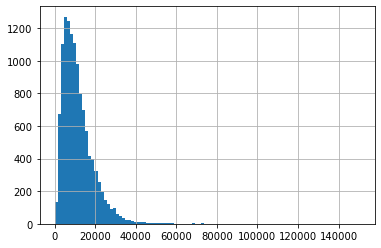

In [28]:
target = df1['KWH']
target.hist(bins=100)
# skewness = rl shift
# liptical = hight is too high for norm dist... outliers on extreem side

In [29]:
df1['KWH'].describe()

count     12083.000000
mean      11288.159398
std        7641.190845
min          17.000000
25%        5837.000000
50%        9623.000000
75%       14765.000000
max      150254.000000
Name: KWH, dtype: float64

(array([1.330e+02, 6.740e+02, 1.102e+03, 1.270e+03, 1.245e+03, 1.167e+03,
        1.110e+03, 9.830e+02, 7.970e+02, 7.000e+02, 5.700e+02, 4.130e+02,
        3.970e+02, 3.230e+02, 2.570e+02, 1.940e+02, 1.460e+02, 1.240e+02,
        9.000e+01, 9.400e+01, 5.900e+01, 4.700e+01, 3.700e+01, 2.100e+01,
        2.600e+01, 2.000e+01, 1.400e+01, 1.000e+01, 1.200e+01, 8.000e+00,
        4.000e+00, 4.000e+00, 2.000e+00, 6.000e+00, 2.000e+00, 2.000e+00,
        6.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

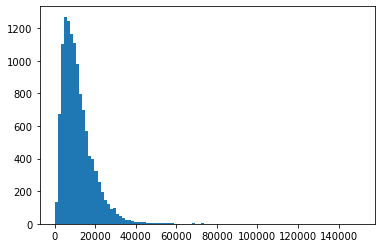

In [15]:
plt.hist(target, bins=100)

In [16]:
# Thoughts... should we remove outliers? 
#             should we normalize to correct skew?



### Column Meanings

In [30]:
# this table shows column headers
df_lay = pd.read_csv(dpath + "public_layout.csv")
df_lay.head()

,Variable Name,Variable Label,Variable Order in File,Variable Type,Length
0,DOEID,Unique identifier for each respondent,1,Character,5
1,REGIONC,Census Region,2,Numeric,8
2,DIVISION,Census Division,3,Numeric,8
3,REPORTABLE_DOMAIN,Reportable states and groups of states,4,Numeric,8
4,TYPEHUQ,Type of housing unit,5,Numeric,8


In [31]:
print(df_lay['Variable Type'].value_counts())

cols_char = df_lay.loc[df_lay['Variable Type'] == 'Character']['Variable Name'].to_list()
cols_char


Numeric      930
Character     10
Name: Variable Type, dtype: int64


['DOEID',
 'METROMICRO',
 'UR',
 'ZTOTSQFT',
 'ZTOTSQFT_EN',
 'ZTOTHSQFT',
 'ZTOTUSQFT',
 'ZTOTCSQFT',
 'ZTOTUCSQFT',
 'IECC_Climate_Pub']

In [93]:
df_lay[:50]

,Variable Name,Variable Label,Variable Order in File,Variable Type,Length
0,DOEID,Unique identifier for each respondent,1,Character,5
1,REGIONC,Census Region,2,Numeric,8
2,DIVISION,Census Division,3,Numeric,8
3,REPORTABLE_DOMAIN,Reportable states and groups of states,4,Numeric,8
4,TYPEHUQ,Type of housing unit,5,Numeric,8
5,NWEIGHT,Final sample weight,6,Numeric,8
6,HDD65,"Heating degree days in 2009, base temperature 65F",7,Numeric,8
7,CDD65,"Cooling degree days in 2009, base temperature 65F",8,Numeric,8
8,HDD30YR,"Heating degree days, 30-year average 1981-2010...",9,Numeric,8
9,CDD30YR,"Cooling degree days, 30-year average 1981-2010...",10,Numeric,8


In [41]:
df_lay.loc[df_lay['Variable Name'] == 'BTUEL']

,Variable Name,Variable Label,Variable Order in File,Variable Type,Length
845,BTUEL,"Total Site Electricity usage, in thousand BTU,...",846,Numeric,8


### Weights Table

In [20]:
# lets look at the weights file
df_w = pd.read_csv(dpath + "recs2009_public_repweights.csv")
print(df_w.shape)
df_w.head()
#The variable NWEIGHT in the data file represents the final sampling weight

# idea: combine NWEIGHT onto the usage table to calculate usage
    # does this have an issue w data leakage as shows the weight broken by toal.. and wouldnt have that ? 

# assume: can use the weights for prediction 


(12083, 246)


,DOEID,NWEIGHT,brr_weight_1,brr_weight_2,brr_weight_3,brr_weight_4,brr_weight_5,brr_weight_6,brr_weight_7,brr_weight_8,...,brr_weight_235,brr_weight_236,brr_weight_237,brr_weight_238,brr_weight_239,brr_weight_240,brr_weight_241,brr_weight_242,brr_weight_243,brr_weight_244
0,1,2471.679705,3628.305158,1392.373673,1271.181424,3528.052756,3478.045539,1164.560766,1215.035282,1204.172316,...,1390.318940,1134.968007,1195.730023,1304.300183,1248.137817,1230.150977,1157.195411,1156.412430,1240.217824,3655.101693
1,2,8599.172010,4408.308000,4247.696575,4450.561135,13207.910560,4178.691121,4271.613426,4219.739488,4229.454405,...,12811.288200,4236.006271,12779.722250,12680.646870,13172.272250,13656.849190,4246.979562,13134.213440,12624.316870,12846.242170
2,3,8969.915921,13664.732100,13655.213030,4359.190122,13086.068610,13721.970010,13459.082130,4749.199418,4689.040317,...,12170.897940,12829.708110,13637.133920,13098.702000,12569.565770,14155.301240,5008.801785,5256.419281,13201.724800,4812.600110
3,4,18003.639600,9456.435434,25723.464490,25125.994190,9334.577574,28340.387380,8659.271182,9079.577826,9200.147549,...,8519.486929,24214.978000,9840.195847,26856.650810,25453.890870,8483.396618,26383.441980,26510.027830,27188.612470,9534.025088
4,5,5999.605242,8659.554041,3269.734038,2910.690905,2798.774832,8544.785536,3091.628917,2939.910109,3251.644196,...,2648.413487,7770.479222,3206.892604,8274.644460,2920.173900,3005.523507,9469.217579,3427.954293,3218.392309,3251.371247


# Model Basic: Linear Reg

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [16]:
df = df_clean
X = np.array(df.drop('KWH', axis=1))
y = np.array(df['KWH'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=54321)

reg = LinearRegression()
reg.fit(X_train, y_train)

print("Train R2:", reg.score(X_train, y_train))
print("Test R2:", reg.score(X_test, y_test))

Train R2: 0.9999999999995469
Test R2: 0.9999999999994303


In [91]:
reg.predict(X_test)

array([15983.98721714,  3118.99991255,  5381.98839907, ...,
        1566.99922082,  3109.00595458, 22742.00737102])

# Pycaret Baseline


In [21]:
from pycaret.regression import *

In [22]:
s = setup(data = df1, target='KWH')

,Description,Value
0,session_id,3673
1,Target,KWH
2,Original Data,"(12083, 940)"
3,Missing Values,False
4,Numeric Features,111
5,Categorical Features,828
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(8458, 2190)"


In [64]:
best = compare_models()
# ok so inital test run with LR is R2 of 1.0 which is too good... do not trust, probably overfit
# 

IntProgress(value=0, description='Processing: ', max=99)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:40:35
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0758,0.0100,0.0995,1.0000,0.0000,0.0000,3.1250
lasso,Lasso Regression,0.1516,0.3382,0.4608,1.0000,0.0001,0.0000,3.7510
ridge,Ridge Regression,0.0646,0.0070,0.0838,1.0000,0.0000,0.0000,3.3690
en,Elastic Net,0.2109,0.3134,0.4995,1.0000,0.0001,0.0000,1.8980
omp,Orthogonal Matching Pursuit,1.6870,25.4829,2.1780,1.0000,0.0011,0.0003,0.1720
br,Bayesian Ridge,0.0889,0.0124,0.1105,1.0000,0.0001,0.0000,47.0660
par,Passive Aggressive Regressor,0.6361,1.0820,1.0163,1.0000,0.0002,0.0001,1.2100
huber,Huber Regressor,11.8039,826.2488,27.4594,1.0000,0.0052,0.0017,8.8110
llar,Lasso Least Angle Regression,64.2722,7632.8850,87.1219,0.9999,0.0234,0.0108,0.1650
gbr,Gradient Boosting Regressor,73.1825,804646.6014,426.2554,0.9899,0.0232,0.0103,6.0090


/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=2.580e-05, with an active set of 32 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 218 iterations, i.e. alpha=1.641e-05, with an active set of 216 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwa

In [92]:
# try just linear regression
lr = create_model('lr', return_train_score=True)

In [2]:
# Q: when the model with LR is too good... why? is it overfit...
# but performs well on the test data....